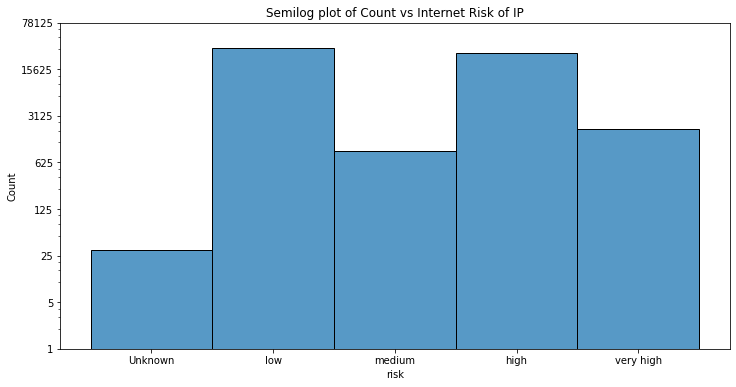

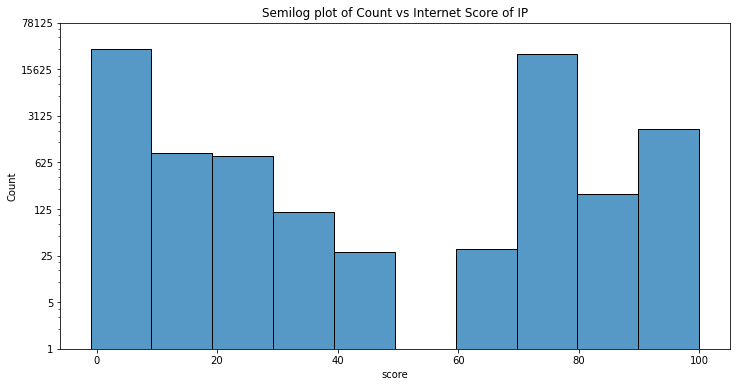

Done!


In [3]:
''' Draw histogram of counts vs risk for the ip addresses found
    in log4j hits as reported in Splunk.
    - Use the output of parse_ip_from_payload.py
    
    Since this program draws graphs it cannot run with %%python
    nor, from the CLI.
'''

ARGS = "all_jndi_hosts_2021.csv --base 5".split()

# Import the modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import dmv_test.mywhois as mywhois
import ipaddress
import argparse
import math

# Arguments --------------------------------------------------------------------

description = '''Draw histogram of counts vs risk for the ip addresses'''
parser = argparse.ArgumentParser(description=description)
parser.add_argument("fn", help="Input file containing ip and hosts")
parser.add_argument("--base", type=int, default=2)

# When executed from CLI do not put in an argument
# myopt = parser.parse_args()

myopt = parser.parse_args(ARGS)
 
# Functions --------------------------------------------------------------------

def ip_only(hosts):
    ## ip_only(df): Return rows where ip is legitimate
    def is_ip(host):
        ## Test if ip address is proper
        try:
            ip_address = ipaddress.ip_address(host)
        except:
            return False
        return True
    return hosts[hosts["ip"].apply(is_ip)].copy()

def fscore(ip_string):
    ## fscore(ipstring): get internet risk score as integer
    r = whois.find(ip_string)
    return int(r["score"]) if r else -1 

def frisk(ip_string):
    ## frisk(ip_string): get internet risk 
    r = whois.find(ip_string)
    return r["risk"] if r else "Unknown"

def tick_labels(x, nbins, base):
    # Return values to labels for semilog y-axis, count
    # x = vector being counted; nbins = # of of bins; semilog
     
    # histogram returns values of x and y axis. Use for # of y-ticks.
    ymax = np.histogram(x, nbins-1)[0].max()
    
    # Compute the number of ticks = min(n) such that 2**n >= ymax
    ticks = math.floor(math.log(ymax)/math.log(base)) + 2
    return base**np.arange(ticks)
    
def semiplot1(hosts, base=2):
    fig, ax = plt.subplots(figsize=(12,6))
    g = sns.histplot(data=hosts, x="risk", ax=ax)
    
    plt.semilogy(base=base)
    ticks = tick_labels(hosts.risk_value, len(categories), base)  
    plt.yticks(ticks, [ f"{x:.0f}" for x in ticks ])
    plt.title("Semilog plot of Count vs Internet Risk of IP")
    plt.show()

def semiplot2(hosts, base=2):
    fig, ax = plt.subplots(figsize=(12,6))
    g1 = sns.histplot(data=hosts, x="score", ax=ax, bins=10)
    
    plt.semilogy(base=base)   
    ticks = tick_labels(hosts.risk_value, len(categories), base)  
    plt.yticks(ticks, [ f"{x:.0f}" for x in ticks ])
    plt.title("Semilog plot of Count vs Internet Score of IP")
    plt.show()

# Main program --------------------------------------------------------------
  
# load the whois database - readonly - global
whois = mywhois.Risk("/home/bkrawchuk/notebooks/dmv_test/mywhois", readonly=True)

# Read the hosts found in the https jndi events returned by the splunk search
raw_hosts = pd.read_csv(myopt.fn)

# Clean list by dropping bad ip addresses (probably host names)
hosts = ip_only(raw_hosts)

# Add internet risk score and risk category
myscore = hosts.loc[:,"ip"].apply(fscore).copy()
myrisk  = hosts.loc[:,"ip"].apply(frisk).copy()

hosts.loc[:,"risk"]  = myrisk
hosts.loc[:,"score"] = myscore

# List: ranking associates numerical risk_value with risk category

ranking = {"Unknown":0, "low":1, "medium":2, "high":3, "very high":4}

# The categories list is ordered by the values of their ranking
categories = [x[0] for x in sorted(ranking.items(), key=lambda item: item[1])]

# Make risk into a factor category
# See https://stackoverflow.com/questions/67205522/set-order-on-sns-histplot
hosts["risk_value"] = hosts.risk.apply(lambda x: ranking[x])

# Add the risk_value to the dataframe so np.histogram can compute range of y-axis
hosts.risk = pd.Categorical(hosts.risk, categories)

# Draw plots
semiplot1(hosts, base=myopt.base)

semiplot2(hosts, base=myopt.base)

print("Done!")

